<a href="https://colab.research.google.com/github/danielbehargithub/MuskTweets-Impact-on-TeslaStock/blob/main/Fintech_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Fintech Project/merged_df.csv')
df.columns
relevant_columns = ['relevance_to_tesla','relevance_to_finance', 'sentiment_score','stock_value_before_tweet','stock_value_after_tweet']
df_relevant = df[relevant_columns]
df_relevant.head()

,relevance_to_tesla,relevance_to_finance,sentiment_score,stock_value_before_tweet,stock_value_after_tweet
0,7,0,5.0,216.89,221.67
1,0,0,5.0,199.86,204.59
2,7,0,5.0,199.86,204.59
3,0,0,3.5,199.86,204.59
4,0,0,8.5,199.86,204.59


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Selecting the relevant columns for the LSTM model
data = df[['relevance_to_tesla', 'relevance_to_finance', 'sentiment_score', 'stock_value_before_tweet', 'stock_value_after_tweet']].dropna()

# Define features (X) and target (y)
X = data[['relevance_to_tesla', 'relevance_to_finance', 'sentiment_score', 'stock_value_before_tweet']].values
y = data['stock_value_after_tweet'].values

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling the features for the LSTM model
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshaping the data to 3D for LSTM (samples, time steps, features)
time_steps = 1  # For example, using 3 time steps
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], time_steps, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], time_steps, X_test_scaled.shape[1]))

# Checking the reshaped data format for LSTM input
X_train_lstm.shape, X_test_lstm.shape


((4384, 1, 4), (1096, 1, 4))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(1, 4)))  # Single LSTM layer
model.add(Dense(1))  # Output layer to predict the stock value after the tweet

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
history = model.fit(X_train_lstm, y_train, epochs=200, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=2)

# Evaluate the model on test data
test_loss = model.evaluate(X_test_lstm, y_test)
print(f'Test Loss: {test_loss}')


Epoch 1/200
137/137 - 2s - 18ms/step - loss: 35610.1055 - val_loss: 36024.5156
Epoch 2/200
137/137 - 0s - 3ms/step - loss: 34103.5195 - val_loss: 33568.8359
Epoch 3/200
137/137 - 1s - 4ms/step - loss: 31190.2891 - val_loss: 30284.4258
Epoch 4/200
137/137 - 0s - 3ms/step - loss: 28005.0078 - val_loss: 27162.9590
Epoch 5/200
137/137 - 1s - 4ms/step - loss: 25116.2637 - val_loss: 24424.1855
Epoch 6/200
137/137 - 1s - 5ms/step - loss: 22596.8750 - val_loss: 22051.0176
Epoch 7/200
137/137 - 0s - 2ms/step - loss: 20403.4531 - val_loss: 19973.6523
Epoch 8/200
137/137 - 0s - 3ms/step - loss: 18478.0977 - val_loss: 18143.1152
Epoch 9/200
137/137 - 1s - 4ms/step - loss: 16771.6270 - val_loss: 16511.4375
Epoch 10/200
137/137 - 1s - 4ms/step - loss: 15245.9287 - val_loss: 15046.1260
Epoch 11/200
137/137 - 1s - 4ms/step - loss: 13873.1201 - val_loss: 13722.6738
Epoch 12/200
137/137 - 1s - 5ms/step - loss: 12631.0117 - val_loss: 12522.6621
Epoch 13/200
137/137 - 1s - 4ms/step - loss: 11502.7754 - va

In [ ]:
# prompt: calculate accuracy metrics for this model

from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the test data
y_pred = model.predict(X_test_lstm)

# Calculate accuracy metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Squared Error (MSE): 49.91287041488297
Root Mean Squared Error (RMSE): 7.064904133453119
R-squared (R2): 0.9632845052047443


In [ ]:
# prompt: can you calculate how far from the real stock value our prediction is for each row in the dataframe?

# Calculate the difference between predicted and actual values
diff = y_pred.flatten() - y_test

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten(), 'Difference': diff})

print(results_df)


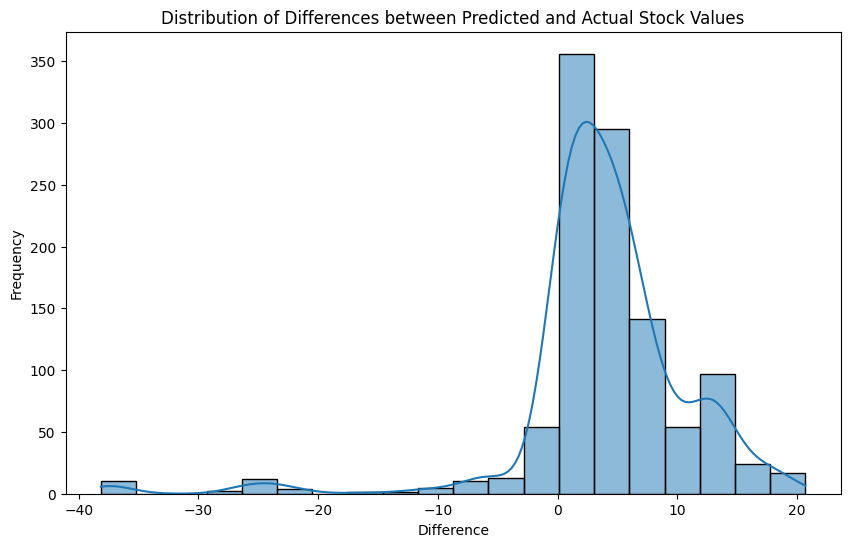

In [ ]:
# prompt: show me the differences distribution in a histogram

# Plot the distribution of the differences
plt.figure(figsize=(10, 6))
sns.histplot(results_df['Difference'], bins=20, kde=True)
plt.title('Distribution of Differences between Predicted and Actual Stock Values')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# prompt: what is the percent of differences between -2 to 2?

# Calculate the percentage of differences between -2 and 2
percentage_within_range = len(results_df[(results_df['Difference'] >= -2) & (results_df['Difference'] <= 2)]) / len(results_df) * 100

print(f'Percentage of differences between -2 and 2: {percentage_within_range:.2f}%')


Percentage of differences between -2 and 2: 29.65%
